<a href="https://colab.research.google.com/github/Patil-Ojas/Face-Mask-Detection/blob/main/facemask_webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt
from imutils import paths
import os

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='webcam_img.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image1/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to webcam_img.jpg


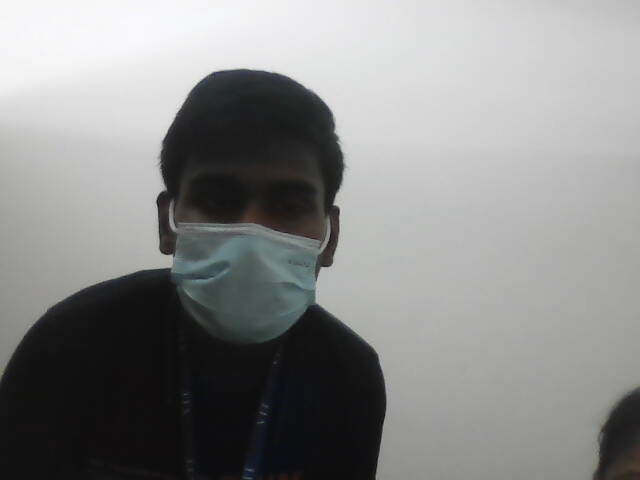

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# from os.path import dirname, join,__file__
prototxtPath = '/content/drive/MyDrive/facemask_data/Facemask_Detection-master/Facemask_Detection-master/deploy.prototxt.txt'
weightsPath= '/content/drive/MyDrive/facemask_data/Facemask_Detection-master/Facemask_Detection-master/res10_300x300_ssd_iter_140000.caffemodel'

In [ ]:
net=cv2.dnn.readNet(weightsPath,prototxtPath)

In [ ]:
model=load_model(r'/content/drive/MyDrive/facemask_data/Facemask_Detection-master/Facemask_Detection-master/model/custom_collab_4000_32_100.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        1849

In [ ]:
dataset = "test"
imagePaths=list(paths.list_images(dataset))
data=[]

for i in imagePaths:
    data.append(i)

In [ ]:
image=cv2.imread("/content/webcam_img.jpg")

In [ ]:
image.shape

(480, 640, 3)

In [ ]:
(h,w)=image.shape[:2]
print(h)
print(w)

480
640


In [ ]:
blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))
blob.shape
print(blob.shape)
net.setInput(blob)
detections = net.forward()

(1, 3, 300, 300)


In [ ]:
detections

array([[[[0.        , 1.        , 0.543122  , ..., 0.23757674,
          0.5177201 , 0.7084994 ],
         [0.        , 1.        , 0.12987079, ..., 4.0009513 ,
          4.8390584 , 4.9855046 ],
         [0.        , 1.        , 0.11513937, ..., 4.0107956 ,
          0.83464634, 4.9878025 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

1/1 [==============================] - 0s 411ms/step
With MASK:  0.83838725
Without MASJ:  0.16161269


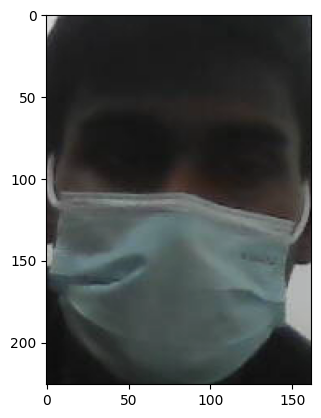

In [ ]:
det =[]
a=0
for i in range(0,detections.shape[2]):
    confidence=detections[0,0,i,2]
    # print("CONF: ",confidence)
    if confidence>0.3:
        box=detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY)=box.astype('int')
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))
        face=image[startY:endY, startX:endX]
        face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        plt.imshow(face)
        face=cv2.resize(face,(96,96))
        det.append(face)
        face=img_to_array(face)
        face=preprocess_input(face)
        face=np.expand_dims(face,axis=0)
        
        (mask,withoutMask)=model.predict(face)[0]
        print("With MASK: ",mask)
        print("Without MASJ: ",withoutMask)
        #determine the class label and color we will use to draw the bounding box and text
        label='No Mask' if withoutMask>mask else 'Mask'
        color=(0,255,0) if label=='Mask' else (255,0,0)
        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)
        
        #display the label and bounding boxes
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)   
        a=a+1

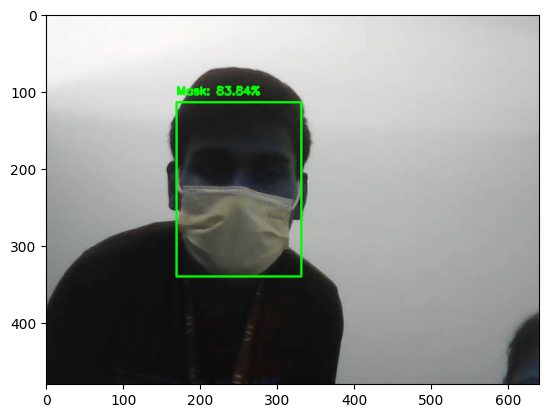

In [ ]:
plt.imshow(image)